## 1. Packages & Parallel Processing Setup

In [14]:
using Distributed
if nworkers() == 1
    addprocs(10)
end
nworkers()
using Statistics, ProgressMeter, Plots
@everywhere using Agents, Random, LinearAlgebra, StaticArrays

## 2. Agent definition

In [15]:
@everywhere @agent struct SIRAgent(ContinuousAgent{2,Float64})
    infected::Bool
    recovered::Bool
    transmission_rate::Float64
    recovery_rate::Float64
    speed::Float64
    scale::Float64
end

## 3. Helper - random unit vector


In [16]:
@everywhere begin
    # Random unit velocity in 2D.
    random_unit_vec() = begin
        v = rand(2) .- 0.5 # Random vector
        v ./= max(norm(v), eps()) # Normalize to unit vector
        SVector{2,Float64}(v) # Convert to static vector for speed
    end
end

## 4. Dynamics - agent_step! - model_step!

In [17]:
@everywhere function agent_step!(a, model)
    susceptible = !a.infected && !a.recovered
    if susceptible
        k = 0 # Count of infected neighbors
        for n in nearby_agents(a, model, 1) # Count infected neighbors within radius 1
            if n.infected == true # Only consider neighbors that were infected at the start of the step
                k += 1 # Increment count of infected neighbors
            end
        end
        p_inf = 1 - ((1 - model.transmission_rate)^k) * (1 - model.spontaneous_infect) # Probability of infection from neighbors and spontaneous infection
        if rand() < p_inf
            a.infected = true
        end
    end

    θmax = deg2rad(model.turning_angle) # Maximum turning angle in radians
    δθ = (2 * rand() - 1) * θmax        # Random angle 
    ϕ = atan(a.vel[2], a.vel[1]) + δθ   # Current direction + angle change
    a.vel = @SVector [cos(ϕ), sin(ϕ)]   # New velocity vector
    move_agent!(a, model, model.speed)
end

In [18]:

@everywhere function model_step!(model)
    for ag in allagents(model)
        if ag.infected && rand() < model.recovery_rate # Probability of recovery
            ag.infected = false  # No longer infected
            ag.recovered = true # Recovered
        end
    end
    # Calculate fraction of infected agents
    inf_frac = count(a -> a.infected, allagents(model)) / nagents(model)
    if inf_frac > model.max_infected_fraction  #
        model.max_infected_fraction = inf_frac # Update max infected fraction if new high
    end
end


## 5. Model initialization

In [19]:
# Initialize SIR model with given parameters
@everywhere function initialize(; n_agents::Int=500,
    β::Float64=0.10, γ::Float64=0.01, spontaneous_infect::Float64=0.0,
    speed::Float64=1.0, scale::Float64=0.7,
    extent::Tuple{<:Real,<:Real}=(100, 100),
    turning_angle::Float64=180.0,
    initial_infected::Int=5)
    space = ContinuousSpace(extent; spacing=1, periodic=true)
    m = StandardABM(
        SIRAgent, space;
        properties=Dict(
            :turning_angle => turning_angle,
            :max_infected_fraction => 0.0,
            :speed => speed,
            :transmission_rate => β,
            :recovery_rate => γ,
            :spontaneous_infect => spontaneous_infect,
        ),
        agent_step!,
        model_step!,
        scheduler=Schedulers.Randomly()
    )
    # Add agents with random positions and initial infection state
    for i in 1:n_agents
        pos = (rand() * extent[1], rand() * extent[2])
        infected = i <= initial_infected
        recovered = false
        a = add_agent!(m, pos, infected, recovered, β, γ, speed, scale)
        a.vel = random_unit_vec()
    end
    return m
end


## 6. Helper - run single simulation 



In [20]:
# Function to run SIR simulation and collect time series data
@everywhere function run_sir_timeseries(β::Float64, γ::Float64, spontaneous_infect::Float64;
    max_steps::Int=10000,
    n_agents::Int=500,
    speed::Float64=1.0,
    turning_angle::Float64=180.0,
    extent::Tuple{<:Real,<:Real}=(100, 100),
    initial_infected::Int=5)

    m = initialize(; n_agents, β, γ, spontaneous_infect, speed, extent, turning_angle, initial_infected)

    S = Float64[]
    I = Float64[]
    R = Float64[]
    push!(S, count(a -> !a.infected && !a.recovered, allagents(m)) / nagents(m))
    push!(I, count(a -> a.infected, allagents(m)) / nagents(m))
    push!(R, count(a -> a.recovered, allagents(m)) / nagents(m))

    steps = 0
    while I[end] > 0.0 && steps < max_steps
        step!(m, 1)
        push!(S, count(a -> !a.infected && !a.recovered, allagents(m)) / nagents(m)) # Susceptible fraction
        push!(I, count(a -> a.infected, allagents(m)) / nagents(m)) # Infected fraction
        push!(R, count(a -> a.recovered, allagents(m)) / nagents(m)) # Recovered fraction
        steps += 1
    end

    return (beta=β, gamma=γ, S=S, I=I, R=R, maxI=m.max_infected_fraction)
end



## 7. Parameter sweep settings

In [21]:
betas = collect(0.01:0.01:0.20)   # β (transmission)
gammas = collect(0.001:0.001:0.02)   # γ (recovery)
spontaneous_infect = 0.0
runs = 100                     # fixed runs per (β,γ)
N = 500
speed = 1.0
turn = 180.0 # turning angle in degrees
extent = (100, 100) # space size
I0 = 5              # initial infected agents
max_steps = 10000;           # safety cap per run

## 8. Helper - padding & averaging 

In [22]:
# We pad the averages to the longest time series 
# Average the SIR curves across multiple runs
pad_to(v::Vector{T}, L::Int) where {T} = (length(v) >= L ? v : vcat(v, fill(v[end], L - length(v)))) # Make a vector of length L by padding with last value in v 
function avg_curves(curves)
    maxlen = maximum(length.(getfield.(curves, :S))) # Get maximum length of S time series
    Smat = reduce(hcat, pad_to.(getfield.(curves, :S), maxlen)) # Pad S
    Imat = reduce(hcat, pad_to.(getfield.(curves, :I), maxlen)) # Pad I
    Rmat = reduce(hcat, pad_to.(getfield.(curves, :R), maxlen)) # Pad R
    S = vec(mean(Smat, dims=2)) # Average S
    I = vec(mean(Imat, dims=2)) # Average I
    R = vec(mean(Rmat, dims=2)) # Average R
    maxI = mean(getfield.(curves, :maxI)) # Average max infected fraction
    (S=S, I=I, R=R, maxI=maxI) # Return as named tuple
end


avg_curves (generic function with 1 method)

## 9. Simulate

In [ ]:
# Run simulations across all β–γ combinations and average results
total_combos = length(betas) * length(gammas)
prog = Progress(total_combos; desc="β–γ combos @ runs=$runs")
results_avg = Dict{Tuple{Float64,Float64},NamedTuple}()
# Loop over all β and γ combinations
for γ in gammas, β in betas
    curves = pmap(1:runs) do _
        run_sir_timeseries(β, γ, spontaneous_infect;
            max_steps=max_steps,
            n_agents=N, speed=speed, turning_angle=turn,
            extent=extent, initial_infected=I0
        )
    end
    results_avg[(β, γ)] = avg_curves(curves)
    next!(prog)
end

β–γ combos @ runs=100   2%|▌                             |  ETA: 0:53:29

## 10. Build and display plots

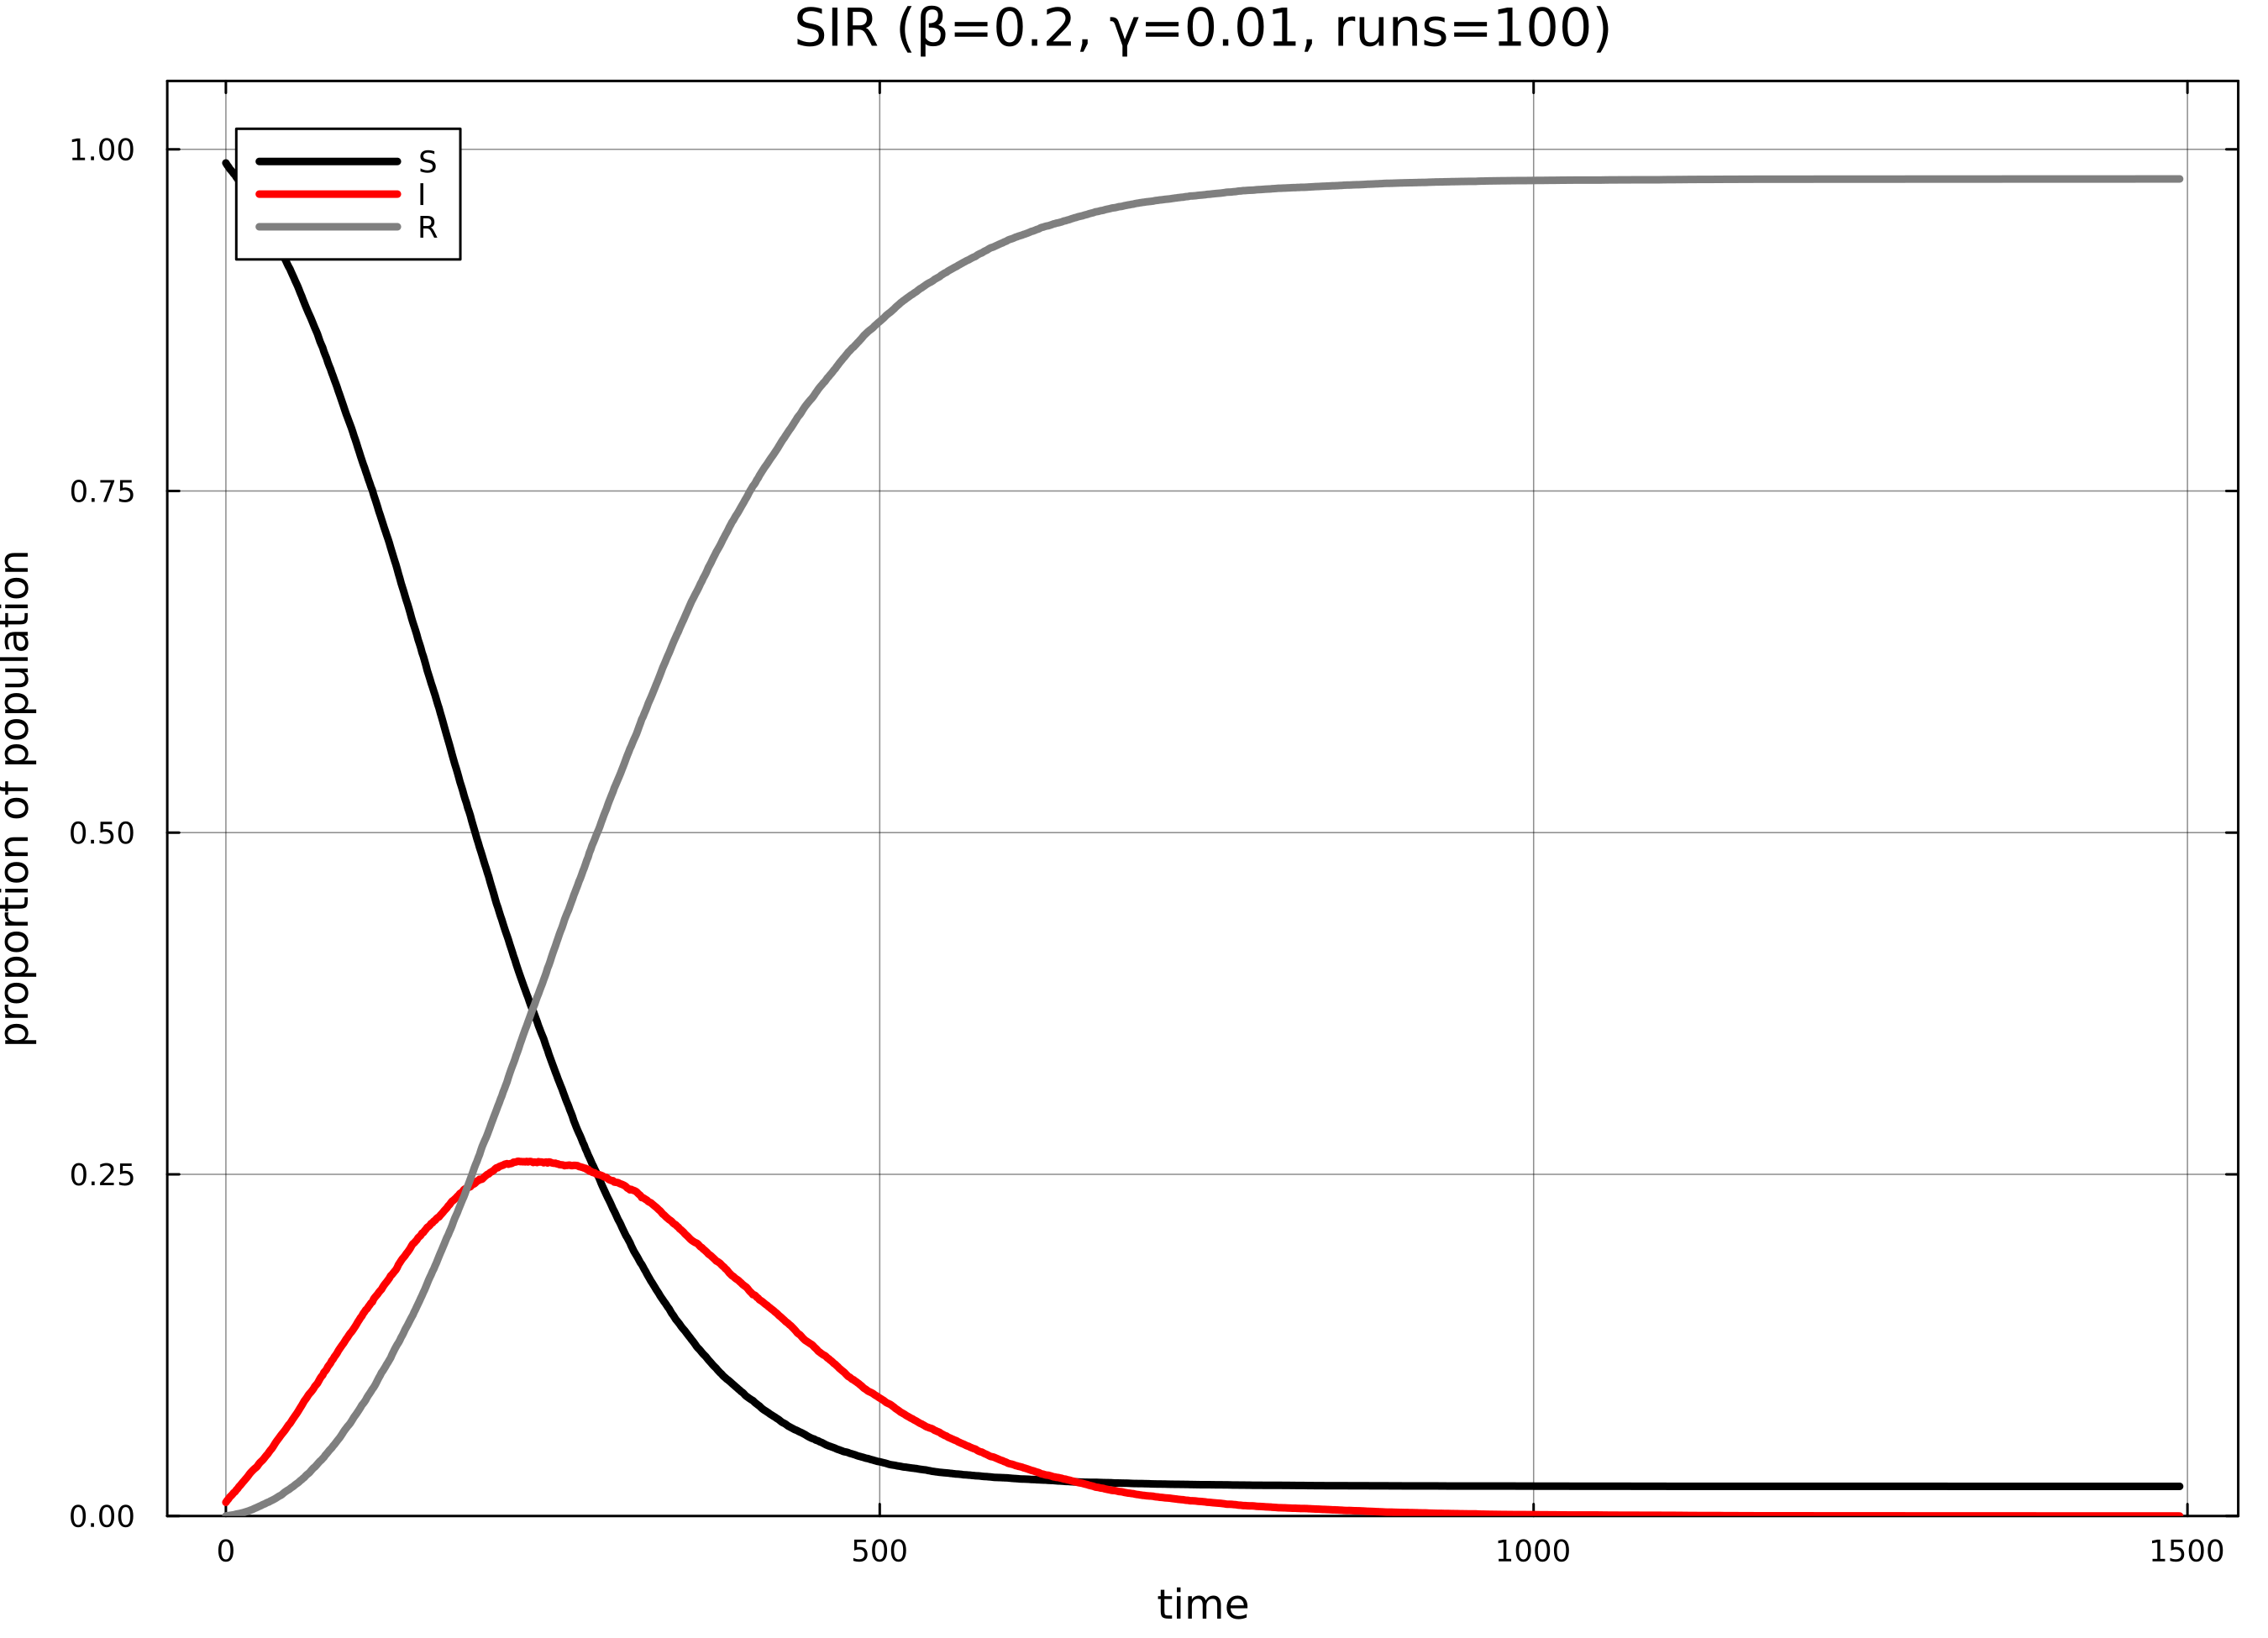

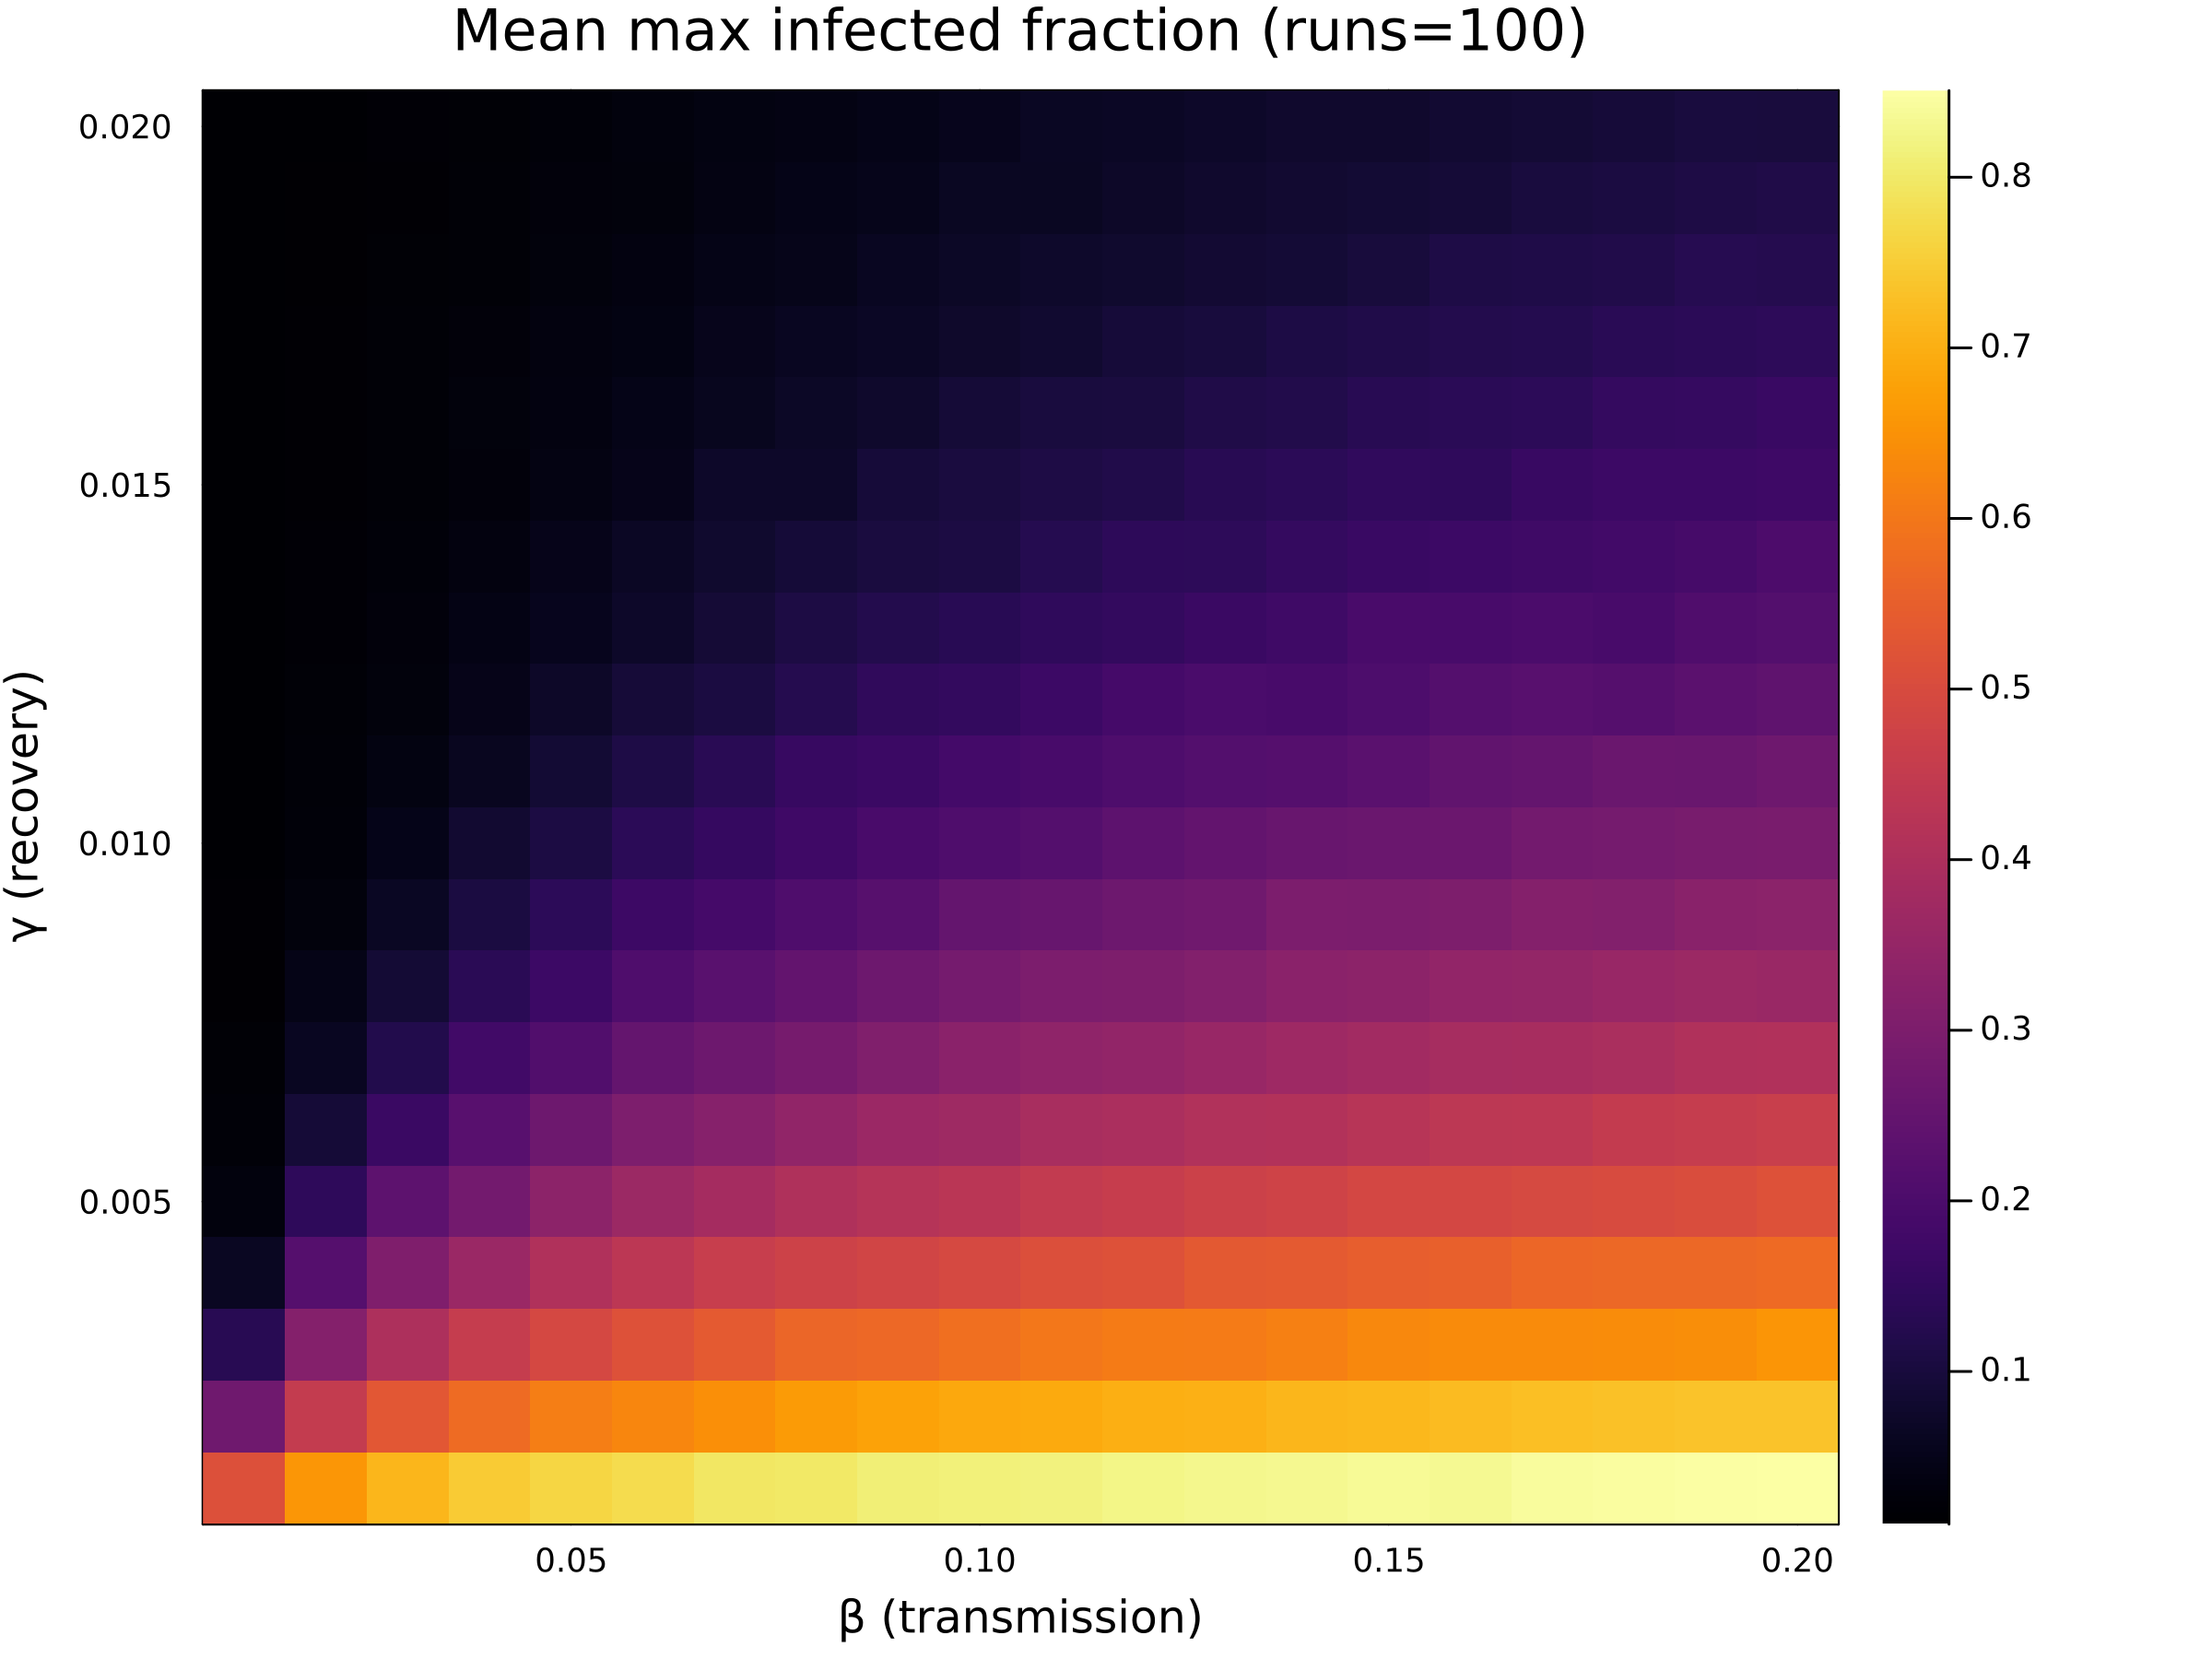

In [ ]:
# Plot
default(size=(900, 650), dpi=300, fmt=:png)

# SIR plot
beta_plot = 0.2 # desired β for plot
gamma_plot = 0.01 # desired γ for plot

# Find β and γ in the grid
iβ = argmin(abs.(betas .- beta_plot));
βsel = betas[iβ];
iγ = argmin(abs.(gammas .- gamma_plot));
γsel = gammas[iγ];
avg = results_avg[(βsel, γsel)]
t = 0:length(avg.S)-1

# SIR time series plot
p_sir = plot(t, avg.S; color=:black, lw=3, label="S",
    xlabel="time", ylabel="proportion of population",
    framestyle=:box, grid=true, gridalpha=0.25, ylims=(0, 1.05), fmt=:png, dpi=300)
plot!(p_sir, t, avg.I; color=:red, lw=3, label="I")
plot!(p_sir, t, avg.R; color=:gray50, lw=3, label="R")
title!(p_sir, "SIR (β=$(round(βsel,digits=2)), γ=$(round(γsel,digits=2)), runs=$runs)")
display(p_sir)

# Heatmap
H = zeros(length(gammas), length(betas))
for (ib, β) in enumerate(betas), (ig, γ) in enumerate(gammas)
    H[ig, ib] = results_avg[(β, γ)].maxI
end
# Heatmap of mean max infected fraction
p_heat = heatmap(betas, gammas, H;
    xlabel="β (transmission)", ylabel="γ (recovery)",
    title="Mean max infected fraction (runs=$runs)",
    c=:inferno, framestyle=:box, grid=false,
    size=(800, 600), right_margin=12Plots.mm, fmt=:png, dpi=300)
display(p_heat)
